# Flow Reactors 01

This notebook works through textbook data that would be typically presented for kinetic analysis using differential tubular or packed bed reactors. Reaction rates in these systems are inferred from the effluent flowrate of product, and they are compiled in tabular format at various reactant concentrations and reaction temperatures.

In [1]:
using DelimitedFiles
using Printf
using Polynomials
using CairoMakie
using LaTeXStrings
using JLD2
using DataFrames
using NumericalIntegration
using Dierckx
using PrettyTables

## Transient phenomena and the significance of steady state (space time vs. clock time)

Measuring a reaction rate is not trivial.

We should generally anticipate that, for catalytic reactors, the "size" of the reactor, which is best defined as the accessible catalytic surface area or number of accessible active sites, are changing in the time domain. Further, we might actually expect that the structure of the surface itself changes as a function of time under reaction conditions.  As an example, consider an alloy (bimetallic) catalyst where changes in reaction conditions causes surface enrichment of one species relative to the other.  In these cases, a "pristine catalyst" prepared by calcination in air or reduction in H2 might be easy to characterize, but it is not necessarily a good approximation for the catalyst surface under reaction conditions as these surfaces may evolve in time, and the time scales for this evolution might be very short or very long. 

As discussed in the analysis of Batch Reactors (Notebook 01), a batch reactor is an inherently dynamic environment where reaction rates should be expected to change in time over the course of the experiment because the composition of the system is changing over the course of the experiment. It is very difficult to deconvolute time-domain changes in reaction rate (almost inevitable in a batch reactor) from time domain changes in the nature or number of catalytic active sites.  The only way to meaningfully address this is to use systems that allow one to decouple reaction kinetics from reactor dynamics.  This is generally facilitated in flow reactors. Flow reactors will reach steady state at some point, which means that product flow rates and rates of reaction must become time invariant (in an ideal system). In a flow reactor at steady state, one infers kinetic information from changes that occur *spatially* across the reactor (i.e., as a function of reactor space time insteady of clock time). When one observes changes in clock time in a flow reactor, they provide insights about dynamic phenomena. Quantifying and understanding these dynamics makes it possible to deconvolute kinetic information from things like induction, deactivation, and restructuring.

Before we do anything else in flow reactor experiments, it is important to establish expectations about how they behave and how we can obtain kinetic information from them.  In considering dynamic phenomena in flow reactors, it is important for us to understand that, just like in a batch reactor, there are inevitable dynamics during transient periods of reactor startup or anytime that we change operating conditions. During this time, we need to consider that the reactor volume is turned over, so the composition in the system is changing, with attendant implications for reaction rate $r = f(T, P, X)$; generally, if systems operate at modest GHSV/LHSV, the reactor free volume turns over many times per minute, so these dynamics tend to dissipate quickly.  We also have to expect that the coverage of surface species changes, generally, on time scales of adsorption and surface reaction.  So it may take time for surface coverages to reach steady state, and until surface coverages reach steady state, we will not see time-invariant reaction rates/production rates. How long will these changes take? It depends strongly on the nature of the reaction mechansim, the relative rates of adsorption and reaction, and the surface species involved in the rate determining step.  Are surface species in the RDS simply adsorbed reactants?  If so, their coverage will rapidly become time invariant and one might see steady state behavior within seconds or minutes.  If, on the other hand, species involved in the RDS are only formed through a sequence of relatively slow surface reactions, it may take minutes, hours, or maybe even days for a system to reach steady state.  It is important to understand that this accumulation of surface species is always a part of kinetics in a flow reactor.  If other dynamic phenomena occur, such as deactivation and restructuring, they overlay with these dynamics.  Contrary to batch reactor data, it is often possible to deconvolute the various temporal phenomena to arrive at a reasonable estimate for a reaction rate that can be attributed to a specific active site.

In [2]:
#################################################################
#  Set of 4 Figure Themes for Makie/CairoMakie                  #
#################################################################

#################################################################
#  Defaults for linear axes x,y plots                           #
#################################################################

theme_linear = Theme(    
    
    #Figure Attributes
    backgroundcolor = "white", 
    font            = "Latin Modern Roman 17", 
    figure_padding  = 30,
    
    #Cycling attributes
    Scatter = (
        cycle = Cycle([[:linecolor, :markercolor, :color, :strokecolor] => :color, :marker], covary = true),
    ),
    
    #Axis attributes
    Axis = (
        
        #Font types
        titlefont          = "Latin Modern Roman 17",
        xlabelfont         = "Latin Modern Roman 17",
        xticklabelfont     = "Latin Modern Roman 17",
        ylabelfont         = "Latin Modern Roman 17",
        yticklabelfont     = "Latin Modern Roman 17",
        
        #Font sizes
        titlesize          = 30,
        xlabelsize         = 30,
        xticklabelsize     = 26,
        ylabelsize         = 30,
        yticklabelsize     = 26,
        
        #x axis properties
        xscale             = identity,
        xticksvisible      = true,
        xtickalign         = 1,
        xminorticks        = IntervalsBetween(5),
        xminorticksvisible = true,
        xminortickalign    = 1,
        xticksize          = 8.0,
        xtickwidth         = 1.5,
        xminorticksize     = 4.0,
        xminortickwidth    = 1.2,
        
        #y axis properties
        yscale             = identity,
        yticksvisible      = true,
        ytickalign         = 1,
        yminorticks        = IntervalsBetween(5),
        yminorticksvisible = true,
        yminortickalign    = 1,
        yticksize          = 8.0,
        ytickwidth         = 1.5,
        yminorticksize     = 4.0,
        yminortickwidth    = 1.2,
        
        #x grid properties
        xgridvisible       = false,
        xminorgridvisible  = false,
        xgridstyle         = :solid,
        xminorgridstyle    = :dot,
        xgridcolor         = "gray50",
        xminorgridcolor    = "gray80",
        xgridwidth         = 0.5,
        xminorgridwidth    = 0.5,
        
        #y grid properties
        ygridvisible       = false,
        yminorgridvisible  = false,
        ygridstyle         = :solid,        
        yminorgridstyle    = :dot,
        ygridcolor         = "gray50",
        yminorgridcolor    = "gray80",
        ygridwidth         = 0.5,
        yminorgridwidth    = 0.5,    
        
        #other axis properties
        spinewidth         = 1.0,
        aspect             = 1.0 
     ),

    #Legend attributes
    Legend = (
        titlefont       = "Latin Modern Roman 17",
        labelfont       = "Latin Modern Roman 17",
        labelsize       = 17,
        framecolor      = (:black, 0.5), 
        backgroundcolor = :white
     )
)

#################################################################
#  Defaults for log-log axes x,y plots                          #
#################################################################

theme_log = Theme(    

    #Figure Attributes
    backgroundcolor = "white", 
    font            = "Latin Modern Roman 17", 
    figure_padding  = 30,
    
    #Cycling attributes
    Scatter = (
        cycle = Cycle([[:linecolor, :markercolor, :color, :strokecolor] => :color, :marker], covary = true),
    ),

    #Axis attributes
    Axis = (
        
        #Font types
        titlefont          = "Latin Modern Roman 17",
        xlabelfont         = "Latin Modern Roman 17",
        xticklabelfont     = "Latin Modern Roman 17",
        ylabelfont         = "Latin Modern Roman 17",
        yticklabelfont     = "Latin Modern Roman 17",
        
        #Font sizes
        titlesize          = 30,
        xlabelsize         = 30,
        xticklabelsize     = 26,
        ylabelsize         = 30,
        yticklabelsize     = 26,
        
        #x axis properties
        xscale             = log10,
        xticksvisible      = true,
        xtickalign         = 1,
        xminorticks        = IntervalsBetween(9),
        xminorticksvisible = true,
        xminortickalign    = 1,
        xticksize          = 8.0,
        xtickwidth         = 1.5,
        xminorticksize     = 4.0,
        xminortickwidth    = 1.2,
        
        #y axis properties
        yscale             = log10,
        yticksvisible      = true,
        ytickalign         = 1,
        yminorticks        = IntervalsBetween(9),
        yminorticksvisible = true,
        yminortickalign    = 1,
        yticksize          = 8.0,
        ytickwidth         = 1.5,
        yminorticksize     = 4.0,
        yminortickwidth    = 1.2,
        
        #x grid properties
        xgridvisible       = true,
        xminorgridvisible  = true,
        xgridstyle         = :solid,
        xminorgridstyle    = :dot,
        xgridcolor         = "gray50",
        xminorgridcolor    = "gray80",
        xgridwidth         = 0.5,
        xminorgridwidth    = 0.5,
        
        #y grid properties
        ygridvisible       = true,
        yminorgridvisible  = true,
        ygridstyle         = :solid,        
        yminorgridstyle    = :dot,
        ygridcolor         = "gray50",
        yminorgridcolor    = "gray80",
        ygridwidth         = 0.5,
        yminorgridwidth    = 0.5,    
        
        #other axis properties
        spinewidth         = 1.0,
        aspect             = 1.0, 
     ),

    #Legend attributes
    Legend = (
        titlefont       = "Latin Modern Roman 17",
        labelfont       = "Latin Modern Roman 17",
        labelsize       = 17,
        framecolor      = (:black, 0.5), 
        backgroundcolor = :white
     )
)

#################################################################
#  Defaults for log x/linear y plots                            #
#################################################################

theme_logx = Theme(    
    #Figure Attributes
    backgroundcolor = "white", 
    font            = "Latin Modern Roman 17", 
    figure_padding  = 30,
    
    #Cycling attributes
    Scatter = (
        cycle = Cycle([[:linecolor, :markercolor, :color, :strokecolor] => :color, :marker], covary = true),
    ),

    #Axis attributes
    Axis = (
        
        #Font types
        titlefont          = "Latin Modern Roman 17",
        xlabelfont         = "Latin Modern Roman 17",
        xticklabelfont     = "Latin Modern Roman 17",
        ylabelfont         = "Latin Modern Roman 17",
        yticklabelfont     = "Latin Modern Roman 17",
        
        #Font sizes
        titlesize          = 30,
        xlabelsize         = 30,
        xticklabelsize     = 26,
        ylabelsize         = 30,
        yticklabelsize     = 26,
        
        #x axis properties
        xscale             = log10,
        xticksvisible      = true,
        xtickalign         = 1,
        xminorticks        = IntervalsBetween(9),
        xminorticksvisible = true,
        xminortickalign    = 1,
        xticksize          = 8.0,
        xtickwidth         = 1.5,
        xminorticksize     = 4.0,
        xminortickwidth    = 1.2,
        
        #y axis properties
        yscale             = identity,
        yticksvisible      = true,
        ytickalign         = 1,
        yminorticks        = IntervalsBetween(5),
        yminorticksvisible = true,
        yminortickalign    = 1,
        yticksize          = 8.0,
        ytickwidth         = 1.5,
        yminorticksize     = 4.0,
        yminortickwidth    = 1.2,
        
        #x grid properties
        xgridvisible       = true,
        xminorgridvisible  = true,
        xgridstyle         = :solid,
        xminorgridstyle    = :dot,
        xgridcolor         = "gray50",
        xminorgridcolor    = "gray80",
        xgridwidth         = 0.5,
        xminorgridwidth    = 0.5,
        
        #y grid properties
        ygridvisible       = true,
        yminorgridvisible  = true,
        ygridstyle         = :solid,        
        yminorgridstyle    = :dot,
        ygridcolor         = "gray50",
        yminorgridcolor    = "gray80",
        ygridwidth         = 0.5,
        yminorgridwidth    = 0.5,    
        
        #other axis properties
        spinewidth         = 1.0,
        aspect             = 1.0, 
     ),

    #Legend attributes
    Legend = (
        titlefont       = "Latin Modern Roman 17",
        labelfont       = "Latin Modern Roman 17",
        labelsize       = 17,
        framecolor      = (:black, 0.5), 
        backgroundcolor = :white
     )
)

#################################################################
#  Defaults for linear x/log y plots                            #
#################################################################

theme_logy = Theme(    

    #Figure Attributes
    backgroundcolor = "white", 
    font            = "Latin Modern Roman 17", 
    figure_padding  = 30,
    
    #Cycling attributes
    Scatter = (
        cycle = Cycle([[:linecolor, :markercolor, :color, :strokecolor] => :color, :marker], covary = true),
    ),

    #Axis attributes
    Axis = (
        
        #Font types
        titlefont          = "Latin Modern Roman 17",
        xlabelfont         = "Latin Modern Roman 17",
        xticklabelfont     = "Latin Modern Roman 17",
        ylabelfont         = "Latin Modern Roman 17",
        yticklabelfont     = "Latin Modern Roman 17",
        
        #Font sizes
        titlesize          = 30,
        xlabelsize         = 30,
        xticklabelsize     = 26,
        ylabelsize         = 30,
        yticklabelsize     = 26,
        
        #x axis properties
        xscale             = identity,
        xticksvisible      = true,
        xtickalign         = 1,
        xminorticks        = IntervalsBetween(5),
        xminorticksvisible = true,
        xminortickalign    = 1,
        xticksize          = 8.0,
        xtickwidth         = 1.5,
        xminorticksize     = 4.0,
        xminortickwidth    = 1.2,
        
        #y axis properties
        yscale             = log10,
        yticksvisible      = true,
        ytickalign         = 1,
        yminorticks        = IntervalsBetween(9),
        yminorticksvisible = true,
        yminortickalign    = 1,
        yticksize          = 8.0,
        ytickwidth         = 1.5,
        yminorticksize     = 4.0,
        yminortickwidth    = 1.2,
        
        #x grid properties
        xgridvisible       = true,
        xminorgridvisible  = true,
        xgridstyle         = :solid,
        xminorgridstyle    = :dot,
        xgridcolor         = "gray50",
        xminorgridcolor    = "gray80",
        xgridwidth         = 0.5,
        xminorgridwidth    = 0.5,
        
        #y grid properties
        ygridvisible       = true,
        yminorgridvisible  = true,
        ygridstyle         = :solid,        
        yminorgridstyle    = :dot,
        ygridcolor         = "gray50",
        yminorgridcolor    = "gray80",
        ygridwidth         = 0.5,
        yminorgridwidth    = 0.5,    
        
        #other axis properties
        spinewidth         = 1.0,
        aspect             = 1.0, 
     ),

    #Legend attributes
    Legend = (
        titlefont       = "Latin Modern Roman 17",
        labelfont       = "Latin Modern Roman 17",
        labelsize       = 17,
        framecolor      = (:black, 0.5), 
        backgroundcolor = :white
     )
)
;

## A Textbook Example

We are considering a generic catalytic reaction:

$$A + B \longrightarrow C$$

We would like to learn more about the reaction orders with respect to species A and species B as well as apparent kinetic parameters that will allow us to capture the temperature dependence of reaction rate.  We decide to utilize a packed bed reactor operating under differential conditions to study this reaction.  For this example, we have ensured that the system is free of mass transfer limitations, heat transfer limitations, and there is no catalyst deactivation. We modulate feed compositions and reactor temperature, and we measure effluent compositions using gas chromatography. Our protocol is to allow our reactor to reach steady state such that the system becomes time invariant. We use that data point to estimate a production rate at those conditions. We then change conditions, allow the system to reach a new steady state, use the steady state data to estimate a production rate at the new condition, and repeat until we have explored the operational space of interest.

The data we compile are placed in a spreadsheet and saved in a .csv format, which we can then easily load into this workbook.

In [3]:
#######################################################################
# Load data obtained in differential packed bed at steady state       #
#######################################################################

KDATA, HEADER = readdlm("SSKINETICS_Flow.csv", ',', Any, '\n', header = true)
KDATA = Float64.(KDATA)
CA  = KDATA[1:5, 1]
rCA = KDATA[1:5, 4]
CB  = KDATA[6:10, 2]
rCB = KDATA[6:10, 4]
T   = KDATA[11:15, 3]
rT  = KDATA[11:15, 4]
;


########################################################################
# Load same data in a data frame to pass into nicely formatted table   #
########################################################################

KDATAFRAME = load_object("SSKINETICS_Flow_df")
pretty_table(KDATAFRAME)


┌────────────┬────────────┬─────────┬────────────┐
│ CA (mol/L) │ CB (mol/L) │   T (K) │ rate (1/s) │
│    Float64 │    Float64 │ Float64 │    Float64 │
├────────────┼────────────┼─────────┼────────────┤
│   0.000794 │      0.112 │   450.0 │    6.31e-6 │
│    0.00944 │      0.112 │   450.0 │   0.000111 │
│      0.112 │      0.112 │   450.0 │   0.000873 │
│       1.33 │      0.112 │   450.0 │     0.0144 │
│       15.8 │      0.112 │   450.0 │      0.159 │
│      0.112 │   0.000794 │   450.0 │    3.97e-8 │
│      0.112 │    0.00944 │   450.0 │    1.14e-5 │
│      0.112 │      0.112 │   450.0 │     0.0011 │
│      0.112 │       1.33 │   450.0 │      0.128 │
│      0.112 │       15.8 │   450.0 │       22.7 │
│      0.112 │      0.112 │   350.0 │    2.62e-6 │
│      0.112 │      0.112 │   400.0 │   0.000107 │
│      0.112 │      0.112 │   450.0 │      0.001 │
│      0.112 │      0.112 │   500.0 │    0.00745 │
│      0.112 │      0.112 │   550.0 │     0.0305 │
└────────────┴────────────┴────

### Analysis and parameter estimation.

Above, we have a nicely planned set of experiments wherein $C_A$, $C_B$, and $T$ are all independently varied while holding the other two parameters fixed.  This allows us to apply the following linearizations to estimate $\alpha$, $\beta$, $E_A$.

$$r = k{C_A}^\alpha{C_B}^\beta$$

$$\log_{10}{(r)} = \log_{10}(k^\prime) + \alpha \log_{10}{(C_A)}$$
$$\log_{10}{(r)} = \log_{10}(k^{\prime \prime}) + \beta \log_{10}{(C_B)}$$
$$\ln{(r)} = \ln(A^\prime) - \frac{E_A}{R}\frac{1}{T}$$

In [4]:
#######################################################
# Perform linear regressions                          #
#######################################################

f1 = fit(log10.(CA), log10.(rCA), 1)
f2 = fit(log10.(CB), log10.(rCB), 1)
f3 = fit(1000 ./T, log.(rT), 1);

In [5]:
#######################################################
# Generate log-log reaction order plot                #
#######################################################

set_theme!(theme_log)
fig1 = Figure(size = (600, 600))
ax1  = Axis(fig1[1,1])
ax2  = Axis(fig1[1,1], yaxisposition = :right, xaxisposition = :top)

#Adjustable Figure properties
xlim_vals  = (1e-4, 1e2)
# xtick_vals = [0.01, 0.1, 1, 10]
ylim_vals  = (1e-8, 1e2)
# ytick_vals = [0.01, 0.1, 1, 10, 100]
xscale_val = log10
yscale_val = log10

ax1.xlabel = L"\mathrm{C_j \, (mol \, L^{-1}})"
ax1.ylabel = L"\mathrm{r \,(s^{-1})}"

ax2.xticklabelsvisible = false
ax2.yticklabelsvisible = false

#Automatically updating Figure properties based on above
xlims!(ax1, xlim_vals)
xlims!(ax2, xlim_vals)

ylims!(ax1, ylim_vals)
ylims!(ax2, ylim_vals)

ax1.xscale = xscale_val
ax2.xscale = xscale_val

ax1.yscale = yscale_val
ax2.yscale = yscale_val

scatter!(ax1, CA, rCA, label = L"C_A", marker = :circle, markersize = 15, strokewidth = 1.25, strokecolor = :blue, color = (:white, 0.0))
lines!(ax1, CA, 10 .^f1.(log10.(CA)), label = L"\alpha = 1.0", color = :black, linestyle = :dash, linewidth = 1.5)
scatter!(ax1, CB, rCB, label = L"C_B", marker = :rect, markersize = 14, strokewidth = 1.25, strokecolor = :red, color = (:white, 0.0))
lines!(ax1, CB, 10 .^f2.(log10.(CB)), label = L"\beta = 2.0", color = :black, linestyle = :dot, linewidth = 1.5)
axislegend(ax1, position = :lt, framevisible = true)
save("FlowOrders.svg", fig1)
CairoMakie.activate!(type = "svg")
;

In [6]:
#######################################################
# Generate Arrhenius plot                             #
#######################################################

set_theme!(theme_linear)
fig2 = Figure(size = (600, 600))
ax1  = Axis(fig2[1,1])
ax2  = Axis(fig2[1,1], yaxisposition = :right, xaxisposition = :top)

#Adjustable Figure properties
xlim_vals  = (1.75, 3)
xtick_vals = 1.75:0.25:3.0
ylim_vals  = (-14, -2)
ytick_vals = -14:2:-2
xscale_val = identity
yscale_val = identity

ax1.xlabel = L"1000/T \, (K^{-1})"
ax1.ylabel = L"\ln{(\mathrm{r})}"

ax2.xticklabelsvisible = false
ax2.yticklabelsvisible = false

#Automatically updating Figure properties based on above
xlims!(ax1, xlim_vals)
xlims!(ax2, xlim_vals)

ylims!(ax1, ylim_vals)
ylims!(ax2, ylim_vals)

ax1.xscale = xscale_val
ax2.xscale = xscale_val

ax1.yscale = yscale_val
ax2.yscale = yscale_val

ax1.xticks = xtick_vals
#ax1.xtickformat = value -> [LaTeXString("10^$value") for value in ["0.01", "0.1", "1", "10"]]
ax2.xticks = xtick_vals

ax1.yticks = ytick_vals
ax2.yticks = ytick_vals

scatter!(ax1, 1000 ./T, log.(rT), marker = :circle, markersize = 15, strokewidth = 1, strokecolor = :blue, color = (:white,0.0))
lines!(ax1, 1000 ./T, f3.(1000 ./T), label = string("EA = ", round(f3[1]*-8.314, digits = 1), " kJ/mol"), color = :black, linestyle = :dash, linewidth = 1.5)
axislegend(ax1, position = :rt, framevisible = true)
save("FlowBarriers.svg", fig2)
CairoMakie.activate!(type = "svg")
;

α = 1.02, β = 2.01, and EA = 74.53 kJ/mol - These are all statistically equal to true parameter values.

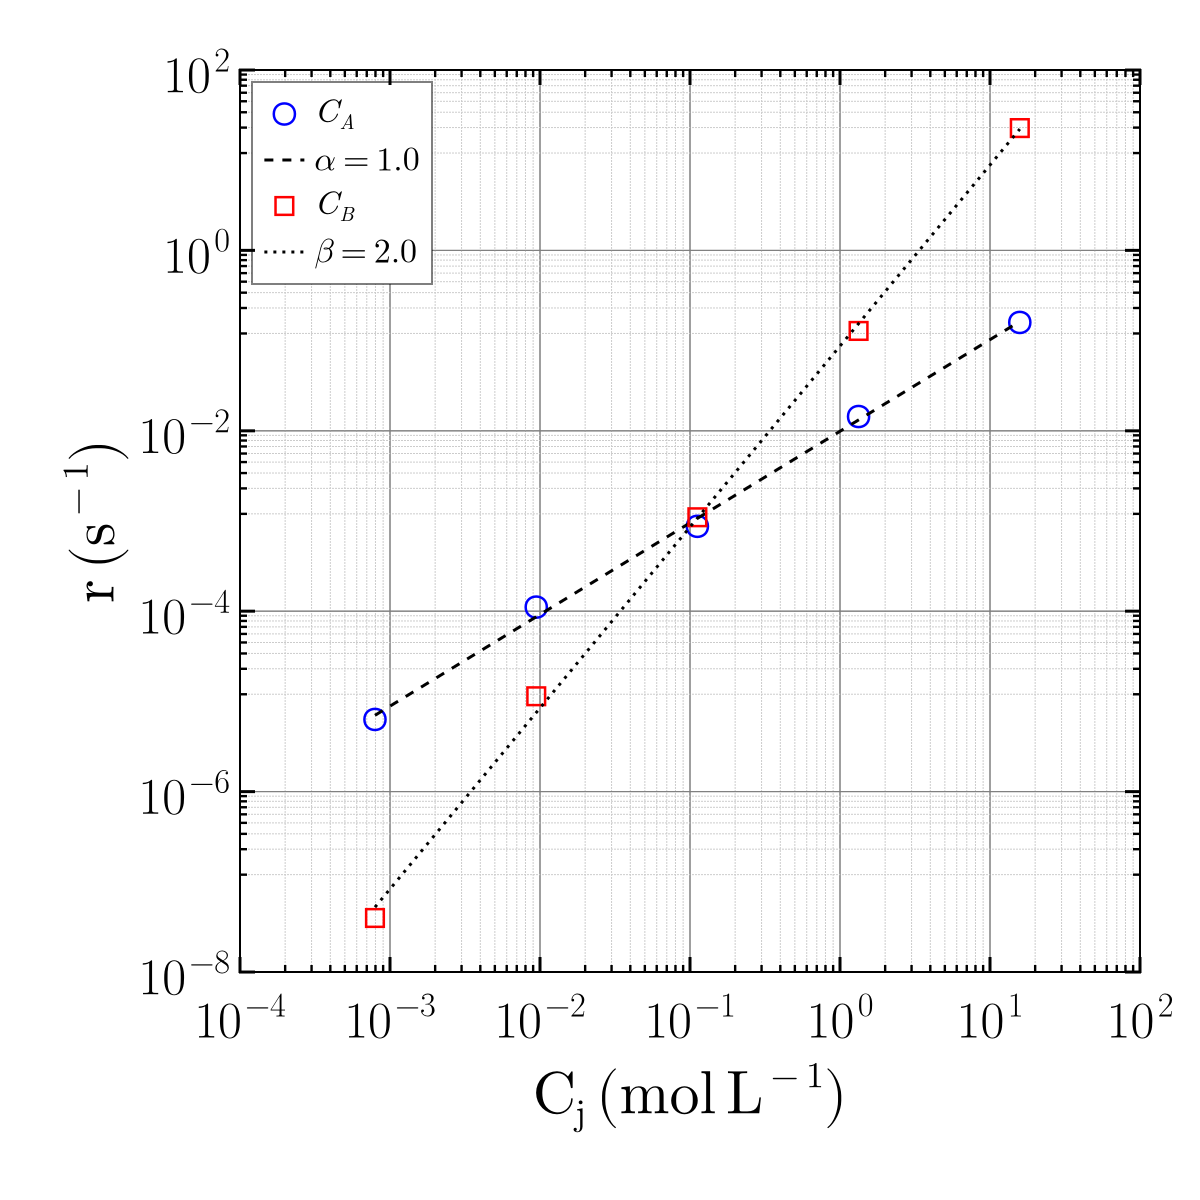

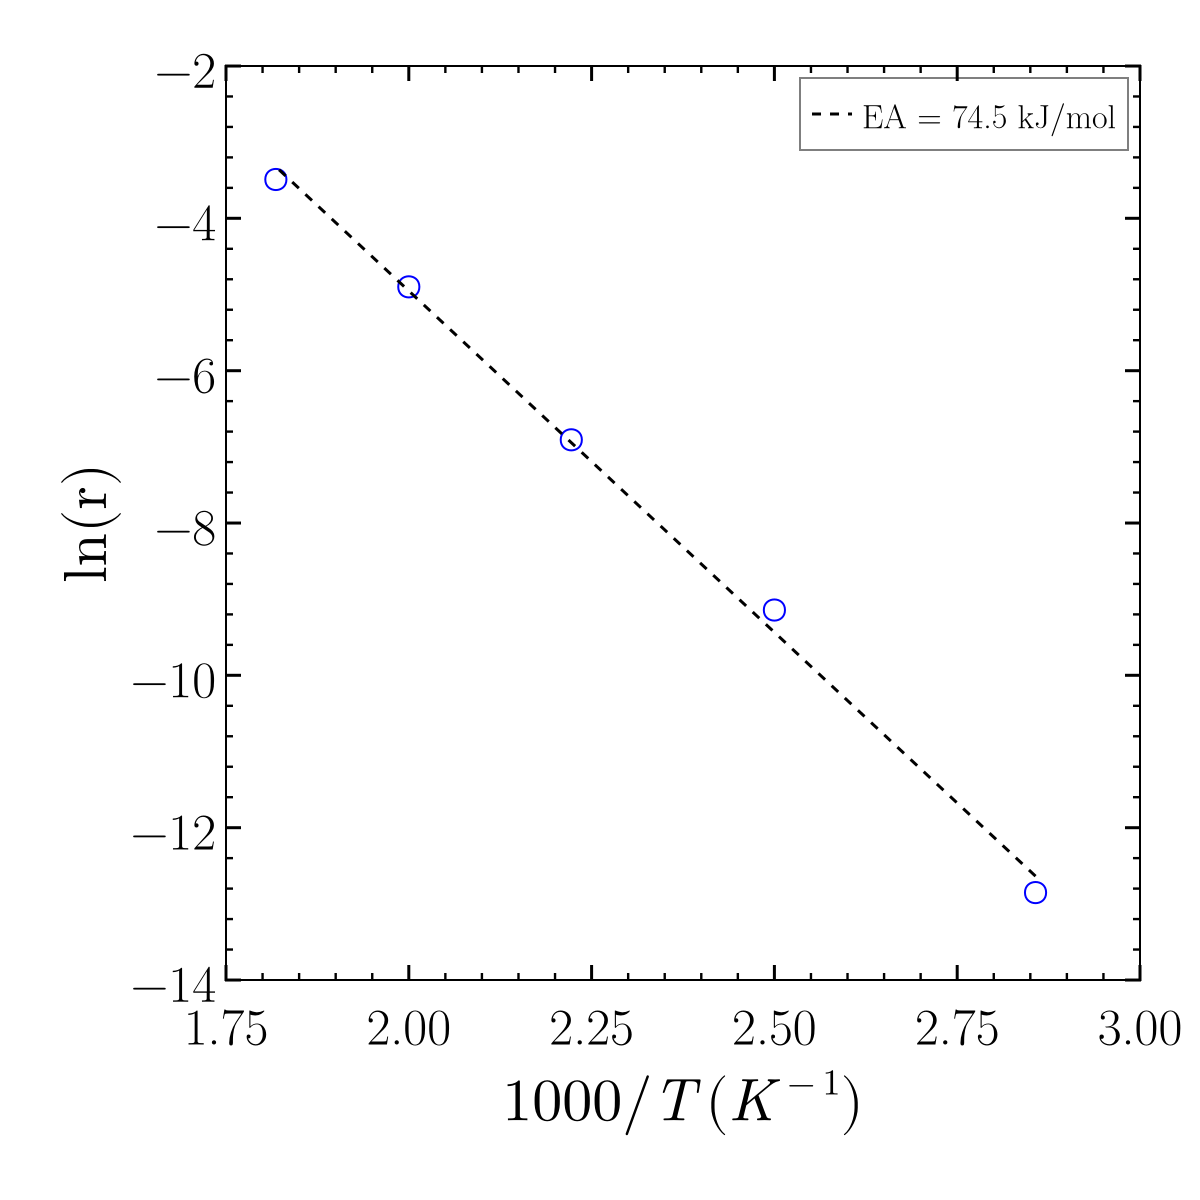

In [7]:
#######################################################
# Display reaction orders and Arrhenius Plots         #
#######################################################

@printf("α = %3.2f, β = %3.2f, and EA = %3.2f kJ/mol - These are all statistically equal to true parameter values.", f1[1], f2[1], -8.314*f3[1]) 
display(fig1)
display(fig2);